In [1]:
import httpx
import asyncio
import pandas as pd
from pathlib import Path

## Baixa Merge

In [ ]:
url_base = 'https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY'
diretorio = "MERGE"
limitador_tarefas = asyncio.Semaphore(7)

In [3]:
inicio = "2019-08-13"
fim = "2023-12-31"

datas = pd.date_range(start=inicio, end=fim, freq="D").tolist()

In [4]:
async def obter_merge(data: pd.Timestamp) -> None:
    """
    Baixa MERGE.

    Parameters
    ----------
    data : pd.Timestamp
        Timestamp
    """
    async with limitador_tarefas:
        async with httpx.AsyncClient() as cliente:

            for hora in range (0, 24):
                hora_str = str(f"{hora:02}")
                arquivo = f'MERGE_CPTEC_{data.year}{data.strftime("%m")}{data.strftime("%d")}{hora_str}.grib2'
                url_requisicao = (
                        f"{url_base}/{data.year}/{data.strftime("%m")}/{data.strftime("%d")}/{arquivo}"
                    )
                print(url_requisicao)
                
                resposta = await cliente.get(url_requisicao, timeout=30)
                await asyncio.sleep(2)

                resposta = await cliente.get(url_requisicao, timeout=None)

                if resposta.status_code == 200:
                    conteudo = resposta.content
                    diretorio_saida = Path(diretorio, arquivo)

                    with open(diretorio_saida, "wb") as arquivo_:
                        arquivo_.write(conteudo)
                        
                    print(f"{arquivo} [ok]")

                else:
                    print(f"Não foi possível obter o {arquivo}.")
                    print(url_requisicao)

In [5]:
agendadas = set()

for data in datas:
    task = obter_merge(data)
    agendadas.add(task)

await asyncio.gather(*agendadas)

https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2020/03/31/MERGE_CPTEC_2020033100.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2021/04/19/MERGE_CPTEC_2021041900.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2022/05/08/MERGE_CPTEC_2022050800.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2023/05/27/MERGE_CPTEC_2023052700.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2020/04/01/MERGE_CPTEC_2020040100.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2021/04/20/MERGE_CPTEC_2021042000.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2022/05/09/MERGE_CPTEC_2022050900.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2023/05/28/MERGE_CPTEC_2023052800.grib2


FileNotFoundError: [Errno 2] No such file or directory: 'MERGE/MERGE_CPTEC_2023052700.grib2'

https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2020/04/02/MERGE_CPTEC_2020040200.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2021/04/21/MERGE_CPTEC_2021042100.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2022/05/10/MERGE_CPTEC_2022051000.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2023/05/29/MERGE_CPTEC_2023052900.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2020/04/03/MERGE_CPTEC_2020040300.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2021/04/22/MERGE_CPTEC_2021042200.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2022/05/11/MERGE_CPTEC_2022051100.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2023/05/30/MERGE_CPTEC_2023053000.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2020/04/04/MERGE_CPTEC_2020040400.grib2
https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY//2021/04/23/MERGE_CPTEC_2021042300.grib2
https://ftp.cptec.in

## Abre arquivo MERGE

In [5]:
import xarray as xr
import rioxarray
import rasterio
from pathlib import Path
import geopandas as gpd

## Funções

In [2]:
def set_lon180(
    da: xr.DataArray,
) -> xr.DataArray:
    """Ajusta a longitude de 0-360 para -180-180."""
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180)).sortby("longitude")
    return da


def set_spatial_dims(
    da: xr.DataArray,
) -> xr.DataArray:
    """Define as dimensões espaciais de um DataArray Xarray."""
    da = da.rio.write_crs("EPSG:4674")
    da = da.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    return da

In [ ]:
caminho_merge = Path("/home/rodrigocaldas/dados_tcc/MERGE/dados_brutos/MERGE_CPTEC_20190814.grib2")
caminho_conceicao = Path("/home/rodrigocaldas/dados_tcc/sub-bacias-isoladas/tocantins/conceicao_do_araguaia.shp")

In [10]:
gdf = gpd.read_file(caminho_conceicao)
gdf = gdf.set_crs("4674")

ds = xr.open_dataset(caminho_merge, engine="cfgrib")
ds = set_lon180(ds)
ds = set_spatial_dims(ds)

da = ds["prec"]

recorte = da.rio.clip(gdf.geometry, gdf.crs, drop=True)

/home/rodrigocaldas/miniforge3/envs/tcc/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


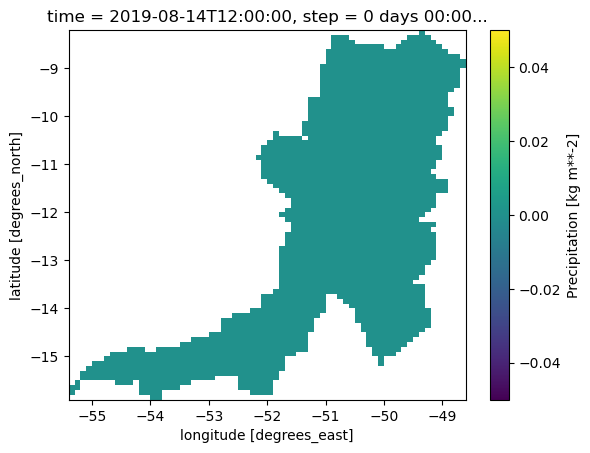

In [11]:
recorte.plot()